## How to do prior and posterior predictive checks in a multinomial-softmax regression

In chapter 4 we introduced softmax regression and showed that (see `model_sf` in the chapter) the most efficient way to model multinomial data is to artificially fix one of the predicted categories to zero (on the parameter space, not on the probability space, of course). If we don't do that, the model will be over-parametrized: since the sum of all the categories' probabilities must sum to 1, the last is determined once we know all the other. 

What happens if we put all the categories into the model (as in `model_s` in the chapter)? Well, it is so dangerous that no one ever dared trying... Kidding aside, the model will probably run with no divergences - as NUTS is very good at dealing with high correlations in the posterior. But it will be slow and inefficient. In other words, we can do better - so let's do it!

Of course, we've already done that in the chapter, so here we'll extend the example and show you how to do prior and posterior predictive checks in a multinomial-softmax regression. These are harder than usual both because of the softmax link that distorts the relation between the parameter space and the outcome space, and because all the probabilities are linked together (if one goes up, another one *must* go down). Let's dive in!

In [130]:
%load_ext lab_black
%load_ext watermark

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import scipy.stats as stats
import theano.tensor as tt

from scipy.special import expit as logistic
from scipy.special import softmax as softmax

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [9]:
iris = sns.load_dataset("iris")

y_s = pd.Categorical(iris["species"]).codes

x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

x_s.shape, y_s.shape, np.unique(y_s)

((150, 4), (150,), array([0, 1, 2], dtype=int8))

In [15]:
with pm.Model() as model_sf:
    α = pm.Normal("α", mu=0.0, sd=2.0, shape=2)
    α_f = pm.Deterministic("α_f", tt.concatenate([[0], α]))

    β = pm.Normal("β", mu=0.0, sd=2.0, shape=(4, 2))
    β_f = pm.Deterministic("β_f", tt.concatenate([np.zeros((4, 1)), β], axis=1))

    μ = α_f + pm.math.dot(x_s, β_f)
    θ = pm.Deterministic("θ", tt.nnet.softmax(μ))
    yl = pm.Categorical("yl", p=θ, observed=y_s)

    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace_sf = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_itc_var = pm.trace_to_dataframe(trace_sf)
az.summary(trace_sf, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [03:28<00:00, 28.81draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],-0.00,0.02,-0.03,0.03,0.0,0.0,1515.88,1012.25,1513.94,1257.30,1.00
α[1],0.00,0.02,-0.03,0.03,0.0,0.0,1655.99,1034.31,1657.12,1481.39,1.00
"β[0,0]",0.00,0.04,-0.07,0.08,0.0,0.0,1124.97,1124.97,1124.89,1403.03,1.00
"β[0,1]",0.00,0.04,-0.08,0.08,0.0,0.0,1130.22,1029.77,1133.93,1066.75,1.00
"β[1,0]",-0.00,0.02,-0.04,0.04,0.0,0.0,1125.10,1125.10,1117.31,1266.11,1.00
"β[1,1]",-0.00,0.02,-0.05,0.04,0.0,0.0,1141.42,1141.42,1145.13,1316.00,1.00
"β[2,0]",-0.00,0.09,-0.16,0.16,0.0,0.0,935.42,935.42,935.92,1221.97,1.00
"β[2,1]",-0.01,0.09,-0.16,0.17,0.0,0.0,814.71,814.71,816.15,984.62,1.01
"β[3,0]",0.00,0.06,-0.11,0.12,0.0,0.0,1178.59,1178.59,1177.31,1370.96,1.00
"β[3,1]",0.00,0.06,-0.11,0.13,0.0,0.0,963.57,963.57,966.54,1178.06,1.01


In [62]:
# generate 50 plausible values of the 4 predictors:
predictor_seq = np.linspace([-3] * 4, [4] * 4)

# mean intercept for each category:
α_m = prior_checks["α_f"].mean(axis=0)

# mean slope of 4 predictors, for each 3 categories:
β_m = prior_checks["β_f"].mean(axis=0)

# linear model:
μ = α_m + np.dot(predictor_seq, β_m)

# go to outcome space:
θ = softmax(μ, axis=1)

In [114]:
# set values of 4 predictors to -3, then 4, and then get predictions:
μ1 = prior_checks["α_f"] + np.dot([-3] * 4, prior_checks["β_f"])
μ2 = prior_checks["α_f"] + np.dot([4] * 4, prior_checks["β_f"])

# go to outcome space:
θ1 = softmax(μ1, axis=1)
θ2 = softmax(μ2, axis=1)

In [128]:
import scipy

scipy.special.expit(0)

0.5

In [133]:
logistic(4)

0.9820137900379085

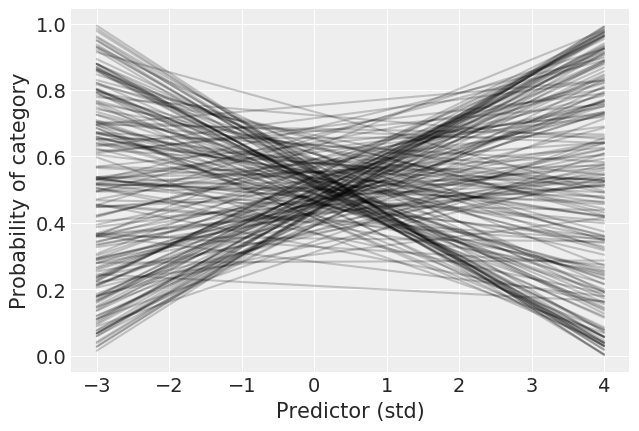

In [141]:
a_s = pm.Normal.dist(mu=0.0, sd=0.5).random(size=200)
b_s = pm.Normal.dist(mu=0.0, sd=0.5).random(size=200)

for y_s in zip(logistic(a_s - 3 * b_s), logistic(a_s + 4 * b_s)):
    plt.plot([-3, 4], y_s, color="k", alpha=0.2)

plt.xlabel("Predictor (std)")
plt.ylabel("Probability of category")

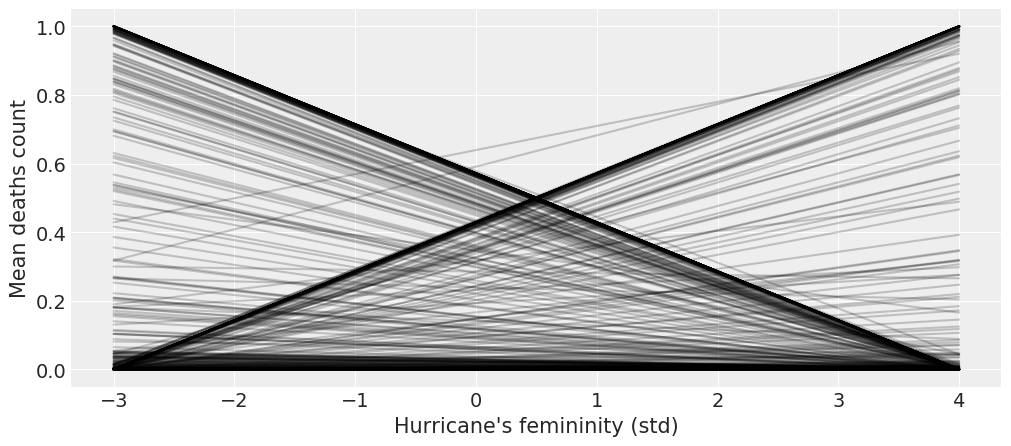

In [117]:
for θ_s in zip(θ1[:, 0], θ2[:, 0]):
    plt.plot([-3, 4], θ_s, color="k", alpha=0.2)
plt.xlabel("Predictor (std)")
plt.ylabel("Probability category 0")

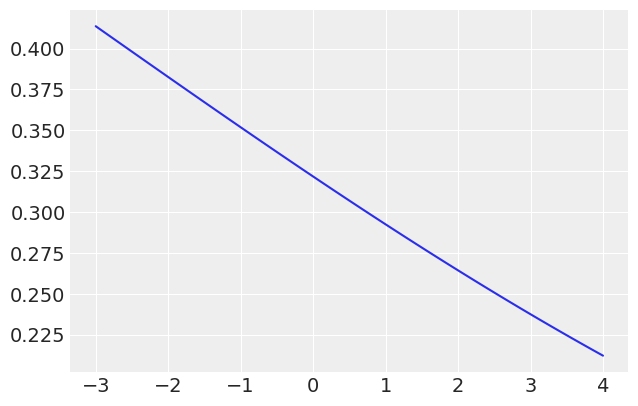

In [70]:
plt.plot(predictor_seq[:, 0], θ[:, 0])

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(17, 8))
i = 0
for row in axes:
    for col in row:
        try:
            az.plot_kde(pp_sample[:, i], ax=col)
            col.axvline(pp_sample[:, i].mean(), linewidth=1.2, color="k", alpha=0.4)
            col.set_xlabel("Prior results")
            col.set_ylabel("Density")
            i += 1
        # it's an 8-spot grid but there are only 7 parties
        except IndexError:
            continue

(50, 4)